In [1]:
%matplotlib inline
import random
import numpy as np
import tensorflow as tf
from laplace.curvature import KFAC
from laplace.sampler import Sampler
from experiments import plots
from experiments.dataset import F3
from experiments.bnn import BNN

2021-07-28 14:44:41.412297: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# tf-laplace demo

In [2]:
NUM_EPOCHS = 1000 # number of training epochs
TAU = 10          # Hyperparameter tau
N = 100           # Hyperparameter N
MC_SAMPLES = 50   # Number of Monte Carlo Samples
NUM_CLASSES = 2   # Number of classes in the multi-label-classification example
RANDOM_SEED = 666 # Random seed value

Seed random number generators

In [3]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

1. create training dataset

In [4]:
ds = F3.create(50, -5.5, 5.5)
training_set = tf.data.Dataset.from_tensor_slices(ds.get()).batch(32)
test_set = tf.data.Dataset.from_tensor_slices(ds.get_test_set(2000)).batch(256)

2021-07-28 14:44:54.772246: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-28 14:44:54.838423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-28 14:44:54.838955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-07-28 14:44:54.838988: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 14:44:54.841134: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-28 14:44:54.841180: I tensorflow/stream_executor/platform/de

2. build and train model

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_dim=2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dense(NUM_CLASSES)
])
criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])
model.fit(training_set, epochs=1000, verbose=True)

Epoch 1/1000


2021-07-28 14:45:09.061923: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 14:45:09.082476: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3599995000 Hz
2021-07-28 14:45:09.143277: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2/2 [==============================] - 1s 3ms/step - loss: 8.1537 - accuracy: 0.6400
Epoch 2/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.9359 - accuracy: 0.6400
Epoch 3/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.7214 - accuracy: 0.6400
Epoch 4/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.5100 - accuracy: 0.6400
Epoch 5/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.3015 - accuracy: 0.6400
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.0959 - accuracy: 0.6400

2021-07-28 14:45:09.440894: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Epoch 24/1000
2/2 [==============================] - 0s 2ms/step - loss: 4.3663 - accuracy: 0.6400
Epoch 25/1000
2/2 [==============================] - 0s 2ms/step - loss: 4.2486 - accuracy: 0.6400
Epoch 26/1000
2/2 [==============================] - 0s 2ms/step - loss: 4.1318 - accuracy: 0.6400
Epoch 27/1000
2/2 [==============================] - 0s 3ms/step - loss: 4.0173 - accuracy: 0.6400
Epoch 28/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.9063 - accuracy: 0.6400
Epoch 29/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.7982 - accuracy: 0.6400

3. approximate curvature and create Bayesian neural network

In [6]:
kfac = KFAC.compute(model, training_set, criterion)
sampler = Sampler.create(kfac, tau=TAU, n=N)
bnn = BNN(model, sampler)

2021-07-28 14:45:24.864493: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x7543970
2021-07-28 14:45:24.864596: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusolver.so.11
2021-07-28 14:45:25.079368: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


4. evaluate bnn on test set

In [7]:
true_labels = tf.zeros([0, NUM_CLASSES], dtype=tf.int64)
points = tf.zeros((0, 2), dtype=tf.float32)
predictions = np.zeros([MC_SAMPLES, 0, NUM_CLASSES], dtype=np.float32)
for i, (x, y) in enumerate(test_set):
    posterior_mean = model.get_weights()
    true_labels = tf.concat([true_labels, tf.cast(y, tf.int64)], axis=0)
    points = tf.concat([points, tf.cast(x, dtype=tf.float32)], axis=0)
    batch_predictions = np.zeros([MC_SAMPLES, x.shape[0], NUM_CLASSES], dtype=np.float32)
    for sample in range(MC_SAMPLES):
        sampler.sample_and_replace_weights()
        batch_predictions[sample] = tf.sigmoid(model.predict(x)).numpy()
        model.set_weights(posterior_mean)
    predictions = np.concatenate([predictions, batch_predictions], axis=1)
    print(f"Evaluated batch {i+1}/{len(test_set)}")

Evaluated batch 1/4
Evaluated batch 2/4
Evaluated batch 3/4
Evaluated batch 4/4


5. visualise uncertainty as predictive standard deviation

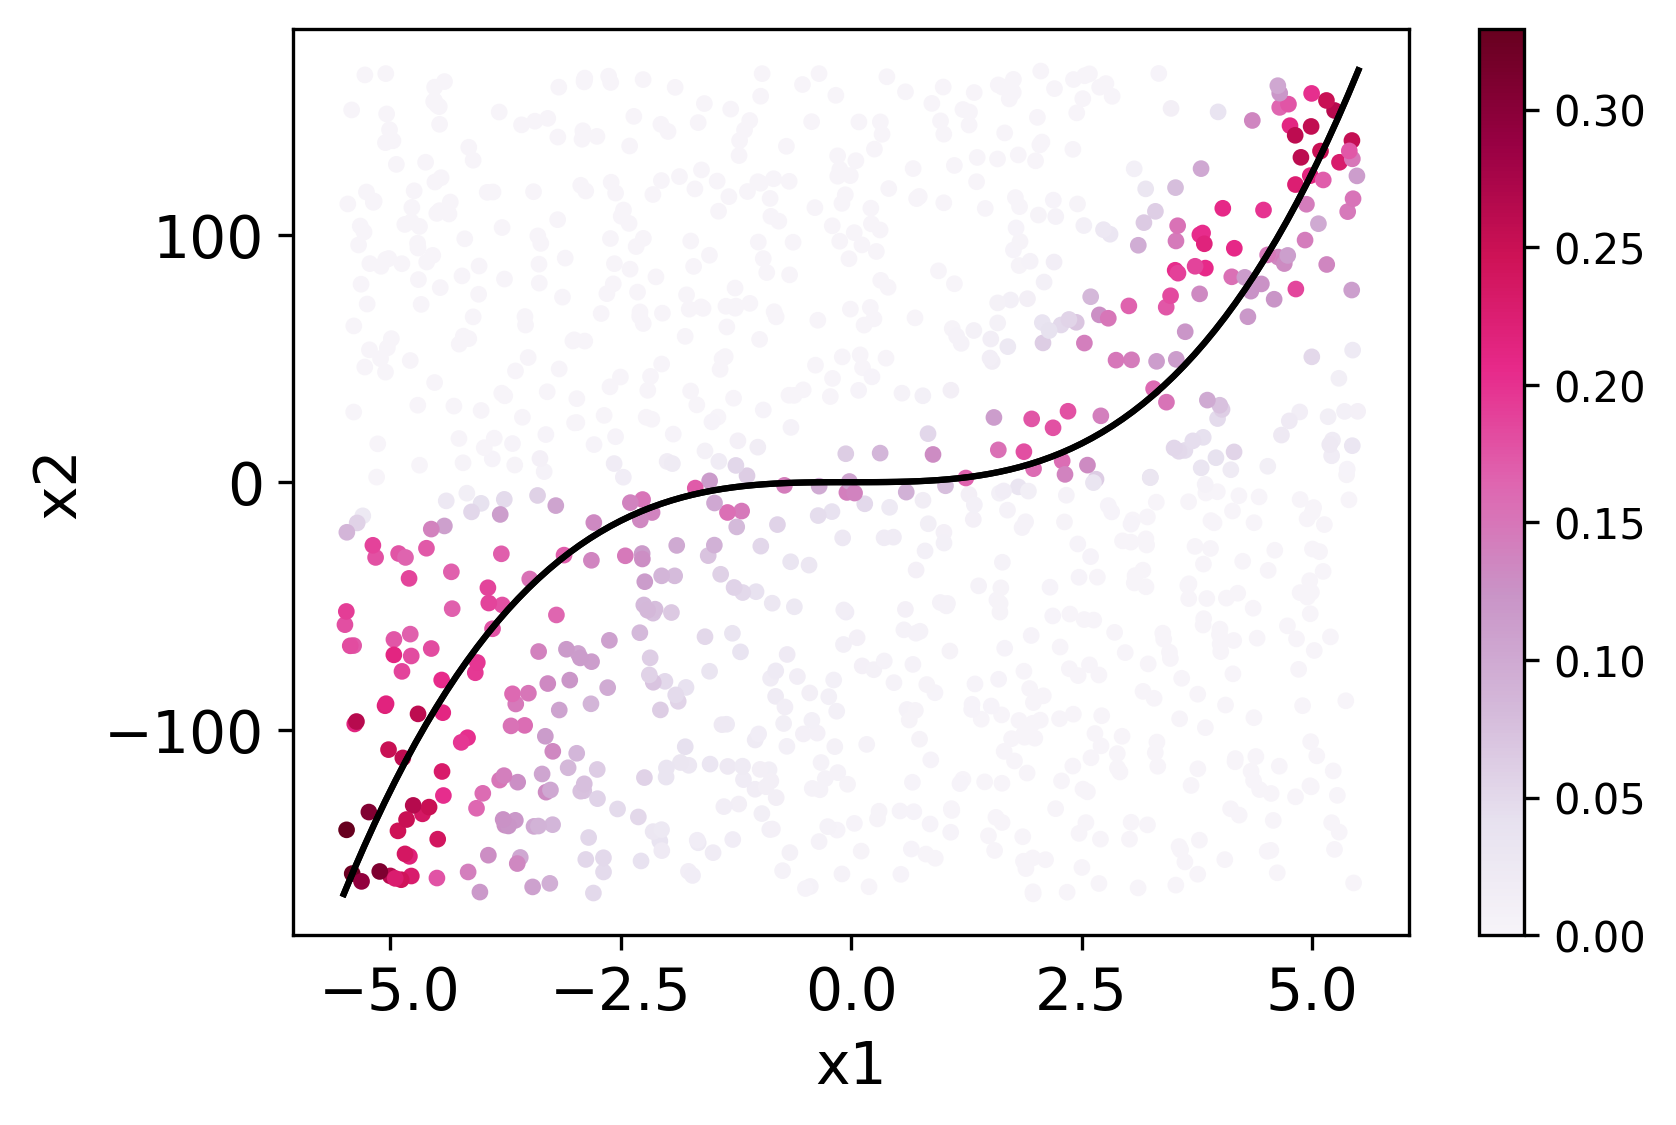

In [8]:
plotter = plots.DatasetPlotter(ds)
heatmap = plotter.plot_heatmap(points,
                               predictions.std(axis=0).sum(axis=1),
                               title=f"predictive standard deviation")
